In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from src import config as cfg

sns.set_theme(style="whitegrid")

## Load and Prepare Data

In [3]:
# load the final dataset
final_data_path = cfg.FIN_MERGED / "model_ready_dataset.parquet"
print(f"loading final dataset from: {final_data_path}")
df = pd.read_parquet(final_data_path)

# drop rows where either target is null
df_clean = df.dropna(subset=['NO2', 'PM2.5']).copy()
df_clean['date'] = pd.to_datetime(df_clean['date'], utc=True)

# ensure data is sorted correctly for time-series operations
df_clean = df_clean.sort_values(['site_code', 'date'])
print(f"data prepared for modeling. shape: {df_clean.shape}")

loading final dataset from: D:\Air pollution london\data\final\aq_traffic\model_ready_dataset.parquet
data prepared for modeling. shape: (499571, 29)


#### Checking for junk values

In [5]:
# look at the 0.1% and 99.9% percentiles
for col in ['NO2','PM2.5','aadf_vehicle_count','wind_speed_10m']:
    lo, hi = df_clean[col].quantile([0.001, 0.999])
    print(f"{col}: {lo:.2f} to {hi:.2f}")

NO2: -1.00 to 135.90
PM2.5: -1.70 to 76.00
aadf_vehicle_count: 1864.00 to 50808.00
wind_speed_10m: 0.80 to 44.34


In [6]:
# remove negative pollution
df_clean['NO2']   = df_clean['NO2'].clip(lower=0)
df_clean['PM2.5'] = df_clean['PM2.5'].clip(lower=0)

# cap extreme winds at the 99.5th percentile
df_clean['wind_speed_10m'] = df_clean['wind_speed_10m'].clip(upper=25)
df_clean['wind_gusts_10m'] = df_clean['wind_gusts_10m'].clip( upper=30)

## Feature Engineering
#### This cell creates the lagged feature and a ULEZ indicator feature that will be used by the models

In [8]:
# # Create lagged features on the cleaned dataframe
df_clean['NO2_lag24h'] = df_clean.groupby('site_code')['NO2'].shift(24)
df_clean['PM2.5_lag24h'] = df_clean.groupby('site_code')['PM2.5'].shift(24)

df_clean['NO2_lag12h'] = df_clean.groupby('site_code')['NO2'].shift(12)
df_clean['PM2.5_lag12h'] = df_clean.groupby('site_code')['PM2.5'].shift(12)

# add ulez and lockdown period
ulez_start_date = pd.to_datetime('2019-04-08', utc=True)
df_clean['is_ulez']     = (df_clean['date'] >= ulez_start_date).astype(int)
df_clean['is_lockdown'] = df_clean['date'].between('2020-03-23','2021-12-29').astype(int)

print("Feature engineering complete.")

Feature engineering complete.


## Common Tuning Parameters
#### This cell defines the hyperparameter search space and cross-validation strategy, which are common to all models.

In [10]:
# Common hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [6, 8, 10]
}

# Common time-series cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

print("Common tuning parameters defined.")

Common tuning parameters defined.


## Model 1: Bexley & Greenwich (BX2, GN0)
#### Model 1 - Data Preparation

In [12]:
sites_1 = ['BX2', 'GN0']
df_1 = df_clean[df_clean['site_code'].isin(sites_1)].copy()
df_1.sort_values('date', inplace=True)

# Drop rows with NaNs created by the shift operations
df_1.dropna(inplace=True)

# Define features and targets
targets = ['NO2', 'PM2.5']
features_1 = [col for col in df_1.columns if col not in targets + 
              ['date', 'site_code', 'site_name','is_ulez', 
               'is_weekend', 'is_holiday', 'is_lockdown','NO2_lag24h',
               'PM2.5_lag24h', 'NO2_lag12h', 'PM2.5_lag12h']]

X1 = df_1[features_1]
y1 = df_1[targets]

# Time-based split for Model 1
split_date_1 = '2024-01-01'
train_mask_1 = df_1['date'] < split_date_1
test_mask_1 = df_1['date'] >= split_date_1
X1_train, X1_test = X1[train_mask_1], X1[test_mask_1]
y1_train, y1_test = y1[train_mask_1], y1[test_mask_1]

print(f"Model 1 data ready. Training shape: {X1_train.shape}, Test shape: {X1_test.shape}")

Model 1 data ready. Training shape: (240982, 22), Test shape: (25877, 22)


#### Model 1 - Baseline Training & Evaluation

Training Baseline Model 1 ... 
Baseline models training complete.

Evaluating Baseline Model 1: 
NO2 R-squared: 0.512
PM2.5 R-squared: 0.276
NO2 MAE: 7.478
PM2.5 MAE: 4.441


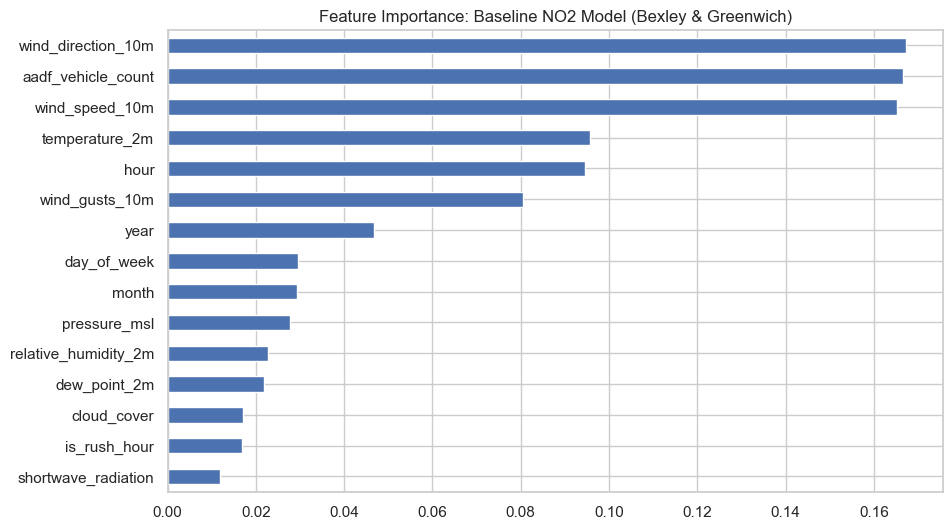

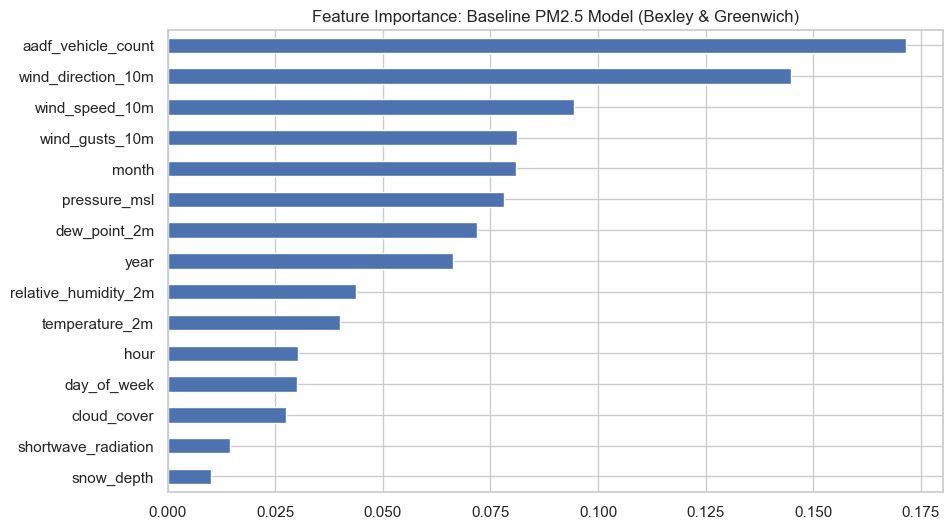

In [14]:
print("Training Baseline Model 1 ... ")

# Train NO2 Model
rf_baseline_no2_1 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
rf_baseline_no2_1.fit(X1_train, y1_train['NO2'])

# Train PM2.5 Model
rf_baseline_pm25_1 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
rf_baseline_pm25_1.fit(X1_train, y1_train['PM2.5'])

print("Baseline models training complete.")

# Evaluate models
print("\nEvaluating Baseline Model 1: ")
y_pred_no2_1 = rf_baseline_no2_1.predict(X1_test)
y_pred_pm25_1 = rf_baseline_pm25_1.predict(X1_test)

# Evaluate model performance
r2_no2_1 = r2_score(y1_test['NO2'], y_pred_no2_1)
r2_pm25_1 = r2_score(y1_test['PM2.5'], y_pred_pm25_1)
mae_no2_1 = mean_absolute_error(y1_test['NO2'], y_pred_no2_1)
mae_pm25_1 = mean_absolute_error(y1_test['PM2.5'], y_pred_pm25_1)

print(f"NO2 R-squared: {r2_no2_1:.3f}")
print(f"PM2.5 R-squared: {r2_pm25_1:.3f}")
print(f"NO2 MAE: {mae_no2_1:.3f}")
print(f"PM2.5 MAE: {mae_pm25_1:.3f}")


# Feature Importance for NO2 Model
importances_no2 = pd.Series(rf_baseline_no2_1.feature_importances_, index=X1_train.columns).nlargest(15)
plt.figure(figsize=(10, 6))
importances_no2.sort_values().plot.barh()
plt.title('Feature Importance: Baseline NO2 Model (Bexley & Greenwich)')
plt.show()

# Feature Importance for PM2.5 Model
importances_pm25 = pd.Series(rf_baseline_pm25_1.feature_importances_, index=X1_train.columns).nlargest(15)
plt.figure(figsize=(10, 6))
importances_pm25.sort_values().plot.barh()
plt.title('Feature Importance: Baseline PM2.5 Model (Bexley & Greenwich)')
plt.show()

#### Model 1 - Hyperparameter Tuning & Final Model

In [16]:
# Define features and targets
features_1 = [col for col in df_1.columns if col not in targets + 
              ['date', 'site_code', 'site_name']]

X1 = df_1[features_1]

# Time-based split for Model 1
train_mask_1 = df_1['date'] < split_date_1
test_mask_1 = df_1['date'] >= split_date_1
X1_train, X1_test = X1[train_mask_1], X1[test_mask_1]
y1_train, y1_test = y1[train_mask_1], y1[test_mask_1]

# Tune for NO2
print("\nTuning Hyperparameters for NO2 (Model 1) ... ")
rf_no2_1 = RandomForestRegressor(random_state=42)
random_search_no2_1 = RandomizedSearchCV(estimator=rf_no2_1, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=2)
random_search_no2_1.fit(X1_train, y1_train['NO2'])

dates_train = df_1[train_mask_1]['date'].reset_index(drop=True)
                                                     
# Print individual fold scores
print("\nIndividual Fold R2 Scores for Best NO2 Model:")
results_no2 = random_search_no2_1.cv_results_
best_index_no2 = random_search_no2_1.best_index_

for i, (train_idx, test_idx) in enumerate(tscv.split(dates_train), start=1):
    # pull the test fold date range
    te = dates_train.iloc[test_idx]
    dr_min, dr_max = te.min().date(), te.max().date()
    fold_score = results_no2[f'split{i-1}_test_score'][best_index_no2]
    print(f"Fold {i} (Date Range: {dr_min} to {dr_max}): R-squared = {fold_score:.3f}")

print("\nBest parameters found for NO2:", random_search_no2_1.best_params_)
best_params_no2_1 = random_search_no2_1.best_params_


# Tune for PM2.5
print("\nTuning Hyperparameters for PM2.5 (Model 1) ... ")
rf_pm25_1 = RandomForestRegressor(random_state=42)
random_search_pm25_1 = RandomizedSearchCV(estimator=rf_pm25_1, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=2)
random_search_pm25_1.fit(X1_train, y1_train['PM2.5'])

print("\nIndividual Fold R2 Scores for Best PM2.5 Model:")
results_pm25 = random_search_pm25_1.cv_results_
best_index_pm25 = random_search_pm25_1.best_index_

for i, (train_idx, test_idx) in enumerate(tscv.split(dates_train), start=1):
    te = dates_train.iloc[test_idx]
    dr_min, dr_max = te.min().date(), te.max().date()
    fold_score = results_pm25[f'split{i-1}_test_score'][best_index_pm25]
    print(f"Fold {i} (Date Range: {dr_min} to {dr_max}): R-squared = {fold_score:.3f}")


print("\nBest parameters found for PM2.5:", random_search_pm25_1.best_params_)
best_params_pm25_1 = random_search_pm25_1.best_params_


# train two seperate models for no2 and pm25 with their best parameters
print("\nTraining Final Tuned Models for Model 1 ... ")
final_no2_model_1 = RandomForestRegressor(**best_params_no2_1, random_state=42, n_jobs=-1)
final_no2_model_1.fit(X1_train, y1_train['NO2'])
final_pm25_model_1 = RandomForestRegressor(**best_params_pm25_1, random_state=42, n_jobs=-1)
final_pm25_model_1.fit(X1_train, y1_train['PM2.5'])
print("Final tuned models trained.")

# Evaluate models on test data
y_pred_no2_1 = final_no2_model_1.predict(X1_test)
y_pred_pm25_1 = final_pm25_model_1.predict(X1_test)
y_pred_tuned_df_1 = pd.DataFrame({'NO2': y_pred_no2_1, 'PM2.5': y_pred_pm25_1}, index=y1_test.index)

r2_no2_tuned_1 = r2_score(y1_test['NO2'], y_pred_tuned_df_1['NO2'])
r2_pm25_tuned_1 = r2_score(y1_test['PM2.5'], y_pred_tuned_df_1['PM2.5'])
print(f"Tuned NO2 R-squared: {r2_no2_tuned_1:.3f}")
print(f"Tuned PM2.5 R-squared: {r2_pm25_tuned_1:.3f}")

#evaluate models on training data
print("\n Evaluating Tuned Models on TRAINING DATA (Model 1) ...")
# Make predictions on the training data
y_pred_train_no2_1 = final_no2_model_1.predict(X1_train)
y_pred_train_pm25_1 = final_pm25_model_1.predict(X1_train)

# Evaluate performance on training data
r2_no2_train_1 = r2_score(y1_train['NO2'], y_pred_train_no2_1)
r2_pm25_train_1 = r2_score(y1_train['PM2.5'], y_pred_train_pm25_1)
mae_no2_train_1 = mean_absolute_error(y1_train['NO2'], y_pred_train_no2_1)
mae_pm25_train_1 = mean_absolute_error(y1_train['PM2.5'], y_pred_train_pm25_1)

print(f"Training NO2 R-squared: {r2_no2_train_1:.3f}")
print(f"Training PM2.5 R-squared: {r2_pm25_train_1:.3f}")
print(f"Training NO2 MAE: {mae_no2_train_1:.3f}")
print(f"Training PM2.5 MAE: {mae_pm25_train_1:.3f}")


Tuning Hyperparameters for NO2 (Model 1) ... 
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Individual Fold R2 Scores for Best NO2 Model:
Fold 1 (Date Range: 2012-05-11 to 2014-09-09): R-squared = 0.674
Fold 2 (Date Range: 2014-09-09 to 2017-01-07): R-squared = 0.678
Fold 3 (Date Range: 2017-01-07 to 2019-05-05): R-squared = 0.629
Fold 4 (Date Range: 2019-05-05 to 2021-08-31): R-squared = 0.492
Fold 5 (Date Range: 2021-08-31 to 2023-12-31): R-squared = 0.651

Best parameters found for NO2: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 20}

Tuning Hyperparameters for PM2.5 (Model 1) ... 
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Individual Fold R2 Scores for Best PM2.5 Model:
Fold 1 (Date Range: 2012-05-11 to 2014-09-09): R-squared = 0.505
Fold 2 (Date Range: 2014-09-09 to 2017-01-07): R-squared = 0.483
Fold 3 (Date Range: 2017-01-07 to 2019-05-05): R-squared = 0.523
Fold 4 (Date Range: 2019

#### Model 1 Manual tuning to reduce overfitting

In [18]:
print("Manually Tuning Model 1 to Reduce Overfitting ... ")

# Start with the best parameters found earlier
manual_params_no2_1 = best_params_no2_1.copy()
manual_params_pm25_1 = best_params_pm25_1.copy()

# Reduce tree depth, require more samples per leaf, and split
manual_params_no2_1['max_depth']        = 15
manual_params_no2_1['min_samples_leaf'] = 25

manual_params_pm25_1['max_depth']        = 15
manual_params_pm25_1['min_samples_leaf'] = 15

manual_no2_model_1 = RandomForestRegressor(
    **manual_params_no2_1,
    random_state=42,
    n_jobs=-1
)
manual_no2_model_1.fit(X1_train, y1_train['NO2'])

manual_pm25_model_1 = RandomForestRegressor(
    **manual_params_pm25_1,
    random_state=42,
    n_jobs=-1
)
manual_pm25_model_1.fit(X1_train, y1_train['PM2.5'])

print("Training complete.")

# Evaluate on test data
y_pred_no2_1 = manual_no2_model_1.predict(X1_test)
y_pred_pm25_1 = manual_pm25_model_1.predict(X1_test)
r2_no2_test = r2_score(y1_test['NO2'], y_pred_no2_1)
r2_pm25_test = r2_score(y1_test['PM2.5'], y_pred_pm25_1)
print(f"Test NO2 R-squared: {r2_no2_test:.3f}")
print(f"Test PM2.5 R-squared: {r2_pm25_test:.3f}")

# Evaluate on training data
y_pred_train_no2_1 = manual_no2_model_1.predict(X1_train)
y_pred_train_pm25_1 = manual_pm25_model_1.predict(X1_train)
r2_no2_train = r2_score(y1_train['NO2'], y_pred_train_no2_1)
r2_pm25_train = r2_score(y1_train['PM2.5'], y_pred_train_pm25_1)
print(f"Training NO2 R-squared: {r2_no2_train:.3f}")
print(f"Training PM2.5 R-squared: {r2_pm25_train:.3f}")


Manually Tuning Model 1 to Reduce Overfitting ... 
Training complete.
Test NO2 R-squared: 0.555
Test PM2.5 R-squared: 0.514
Training NO2 R-squared: 0.767
Training PM2.5 R-squared: 0.685


## Model 2: Camden & Hackney (BL0, HK6)
#### Model 2 - Data Preparation

In [20]:
sites_2 = ['BL0', 'HK6']
df_2 = df_clean[df_clean['site_code'].isin(sites_2)].copy()
df_2.sort_values('date', inplace=True)

# Drop rows with NaNs created by the shift operations
df_2.dropna(inplace=True)

# Define features and targets
targets = ['NO2', 'PM2.5']
features_2 = [col for col in df_2.columns if col not in targets + ['date', 'site_code', 'site_name','is_ulez', 
               'is_weekend', 'is_holiday', 'is_lockdown','NO2_lag24h',
               'PM2.5_lag24h', 'NO2_lag12h', 'PM2.5_lag12h']]
X2 = df_2[features_2]
y2 = df_2[targets]

# Time-based split for Model 2
split_date_2 = '2022-01-01'
train_mask_2 = df_2['date'] < split_date_2
dates_train2 = df_2[train_mask_2]['date'].reset_index(drop=True)
test_mask_2 = df_2['date'] >= split_date_2
X2_train, X2_test = X2[train_mask_2], X2[test_mask_2]
y2_train, y2_test = y2[train_mask_2], y2[test_mask_2]

print(f"Model 2 data ready. Training shape: {X2_train.shape}, Test shape: {X2_test.shape}")

Model 2 data ready. Training shape: (206227, 22), Test shape: (26389, 22)


#### Model 2 - Baseline Training & Evaluation

Training Baseline Model 2 ...
Baseline models training complete.

Evaluating Baseline Model 2: 
NO2 R-squared: 0.489
PM2.5 R-squared: 0.072
NO2 MAE: 9.037
PM2.5 MAE: 3.984


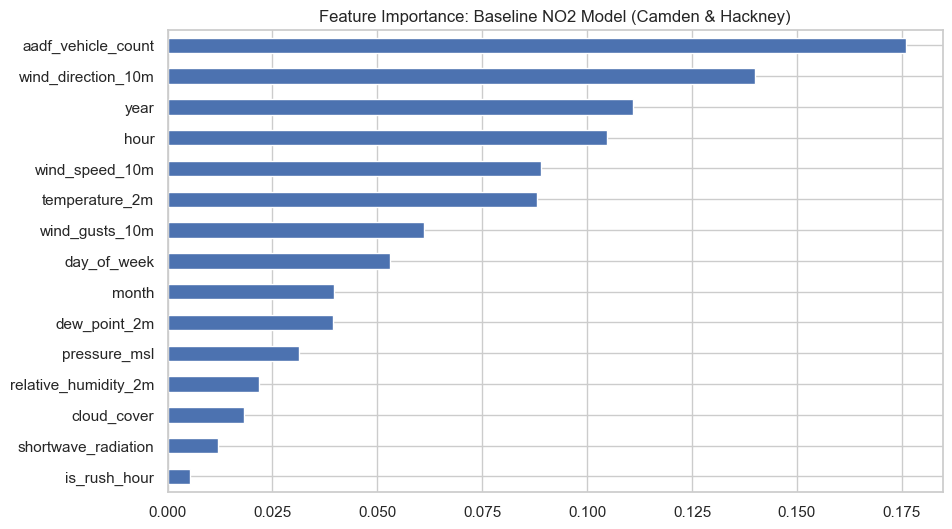

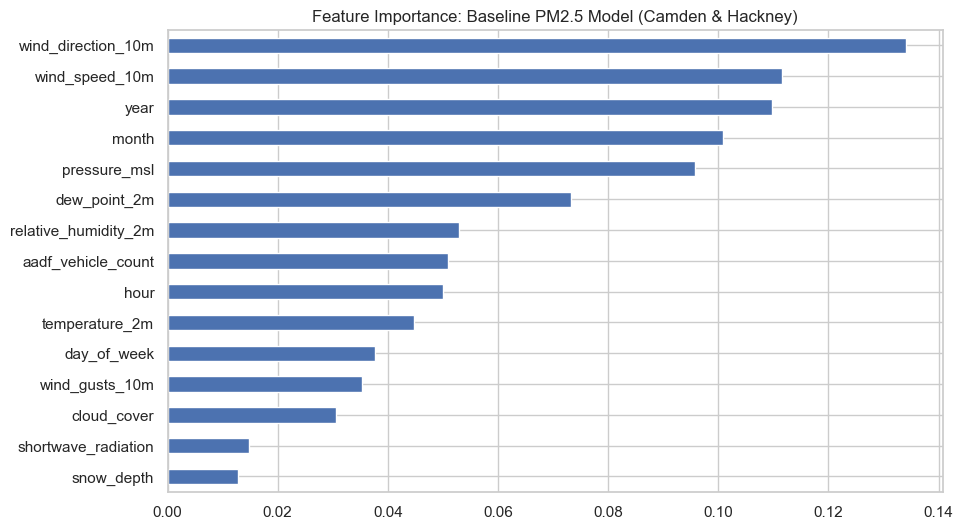

In [22]:
print("Training Baseline Model 2 ...")

# Train NO2 Model
rf_baseline_no2_2 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
rf_baseline_no2_2.fit(X2_train, y2_train['NO2'])

# Train PM2.5 Model
rf_baseline_pm25_2 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
rf_baseline_pm25_2.fit(X2_train, y2_train['PM2.5'])

print("Baseline models training complete.")


print("\nEvaluating Baseline Model 2: ")
y_pred_no2_2 = rf_baseline_no2_2.predict(X2_test)
y_pred_pm25_2 = rf_baseline_pm25_2.predict(X2_test)

# Evaluate model performance
r2_no2_2 = r2_score(y2_test['NO2'], y_pred_no2_2)
r2_pm25_2 = r2_score(y2_test['PM2.5'], y_pred_pm25_2)
mae_no2_2 = mean_absolute_error(y2_test['NO2'], y_pred_no2_2)
mae_pm25_2 = mean_absolute_error(y2_test['PM2.5'], y_pred_pm25_2)

print(f"NO2 R-squared: {r2_no2_2:.3f}")
print(f"PM2.5 R-squared: {r2_pm25_2:.3f}")
print(f"NO2 MAE: {mae_no2_2:.3f}")
print(f"PM2.5 MAE: {mae_pm25_2:.3f}")


# Feature Importance for NO2 Baseline Model
importances_no2_2 = pd.Series(rf_baseline_no2_2.feature_importances_, index=X2_train.columns).nlargest(15)
plt.figure(figsize=(10, 6))
importances_no2_2.sort_values().plot.barh()
plt.title('Feature Importance: Baseline NO2 Model (Camden & Hackney)')
plt.show()

# Feature Importance for PM2.5 Baseline Model
importances_pm25_2 = pd.Series(rf_baseline_pm25_2.feature_importances_, index=X2_train.columns).nlargest(15)
plt.figure(figsize=(10, 6))
importances_pm25_2.sort_values().plot.barh()
plt.title('Feature Importance: Baseline PM2.5 Model (Camden & Hackney)')
plt.show()

#### Model 2 - Hyperparameter Tuning & Final Model

In [24]:
# Define features and targets
features_2 = [col for col in df_2.columns if col not in targets + ['date', 'site_code', 'site_name']]
X2 = df_2[features_2]

# Time-based split for Model 2
split_date_2 = '2022-01-01'
train_mask_2 = df_2['date'] < split_date_2
dates_train2 = df_2[train_mask_2]['date'].reset_index(drop=True)
test_mask_2 = df_2['date'] >= split_date_2
X2_train, X2_test = X2[train_mask_2], X2[test_mask_2]
y2_train, y2_test = y2[train_mask_2], y2[test_mask_2]
# Tune for NO2 
print("\nTuning Hyperparameters for NO2 (Model 2) ... ")
rf_no2_2 = RandomForestRegressor(random_state=42)
random_search_no2_2 = RandomizedSearchCV(estimator=rf_no2_2, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=2)
random_search_no2_2.fit(X2_train, y2_train['NO2'])

# Print individual fold scores 
print("\nIndividual Fold R2 Scores for Best NO2 Model (Model 2):")
results_no2_2 = random_search_no2_2.cv_results_
best_index_no2_2 = random_search_no2_2.best_index_

for i, (train_idx, test_idx) in enumerate(tscv.split(dates_train2), start=1):
    te = dates_train2.iloc[test_idx]
    dr_min, dr_max = te.min().date(), te.max().date()
    fold_score = results_no2_2[f'split{i-1}_test_score'][best_index_no2_2]
    print(f"Fold {i} (Date Range: {dr_min} to {dr_max}): R-squared = {fold_score:.3f}")


print("\nBest parameters found for NO2:", random_search_no2_2.best_params_)
best_params_no2_2 = random_search_no2_2.best_params_


# Tune for PM2.5 
print("\nTuning Hyperparameters for PM2.5 (Model 2) ... ")
rf_pm25_2 = RandomForestRegressor(random_state=42)
random_search_pm25_2 = RandomizedSearchCV(estimator=rf_pm25_2, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=2)
random_search_pm25_2.fit(X2_train, y2_train['PM2.5'])

print("\nIndividual Fold R2 Scores for Best PM2.5 Model (Model 2):")
results_pm25_2 = random_search_pm25_2.cv_results_
best_index_pm25_2 = random_search_pm25_2.best_index_

for i, (train_idx, test_idx) in enumerate(tscv.split(dates_train2), start=1):
    te = dates_train2.iloc[test_idx]
    dr_min, dr_max = te.min().date(), te.max().date()
    fold_score = results_pm25_2[f'split{i-1}_test_score'][best_index_pm25_2]
    print(f"Fold {i} (Date Range: {dr_min} to {dr_max}): R-squared = {fold_score:.3f}")


print("\nBest parameters found for PM2.5:", random_search_pm25_2.best_params_)
best_params_pm25_2 = random_search_pm25_2.best_params_


# train two seperate models for no2 and pm25 with their best parameters
print("\nTraining Final Tuned Models for Model 2 ... ")
final_no2_model_2 = RandomForestRegressor(**best_params_no2_2, random_state=42, n_jobs=-1)
final_no2_model_2.fit(X2_train, y2_train['NO2'])
final_pm25_model_2 = RandomForestRegressor(**best_params_pm25_2, random_state=42, n_jobs=-1)
final_pm25_model_2.fit(X2_train, y2_train['PM2.5'])
print("Final tuned models trained.")

# Evaluate models
print("\nEvaluating Tuned Models for Model 2 ... ")
y_pred_no2_2 = final_no2_model_2.predict(X2_test)
y_pred_pm25_2 = final_pm25_model_2.predict(X2_test)
y_pred_tuned_df_2 = pd.DataFrame({'NO2': y_pred_no2_2, 'PM2.5': y_pred_pm25_2}, index=y2_test.index)

r2_no2_tuned_2 = r2_score(y2_test['NO2'], y_pred_tuned_df_2['NO2'])
r2_pm25_tuned_2 = r2_score(y2_test['PM2.5'], y_pred_tuned_df_2['PM2.5'])
print(f"Tuned NO2 R-squared: {r2_no2_tuned_2:.3f}")
print(f"Tuned PM2.5 R-squared: {r2_pm25_tuned_2:.3f}")


Tuning Hyperparameters for NO2 (Model 2) ... 
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Individual Fold R2 Scores for Best NO2 Model (Model 2):
Fold 1 (Date Range: 2012-01-01 to 2013-12-30): R-squared = 0.583
Fold 2 (Date Range: 2013-12-30 to 2015-12-29): R-squared = 0.613
Fold 3 (Date Range: 2015-12-29 to 2017-12-26): R-squared = 0.557
Fold 4 (Date Range: 2017-12-26 to 2019-12-25): R-squared = 0.498
Fold 5 (Date Range: 2019-12-25 to 2021-12-31): R-squared = 0.382

Best parameters found for NO2: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 30}

Tuning Hyperparameters for PM2.5 (Model 2) ... 
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Individual Fold R2 Scores for Best PM2.5 Model (Model 2):
Fold 1 (Date Range: 2012-01-01 to 2013-12-30): R-squared = 0.449
Fold 2 (Date Range: 2013-12-30 to 2015-12-29): R-squared = 0.490
Fold 3 (Date Range: 2015-12-29 to 2017-12-26): R-squared = 0.505
Fold

#### Evaluation on Training Data

In [26]:
print("\n Evaluating Tuned Models on TRAINING DATA (Model 2) ... ")
# Make predictions on the training data
y_pred_train_no2_2 = final_no2_model_2.predict(X2_train)
y_pred_train_pm25_2 = final_pm25_model_2.predict(X2_train)

# Evaluate performance on training data
r2_no2_train_2 = r2_score(y2_train['NO2'], y_pred_train_no2_2)
r2_pm25_train_2 = r2_score(y2_train['PM2.5'], y_pred_train_pm25_2)
mae_no2_train_2 = mean_absolute_error(y2_train['NO2'], y_pred_train_no2_2)
mae_pm25_train_2 = mean_absolute_error(y2_train['PM2.5'], y_pred_train_pm25_2)

print(f"Training NO2 R-squared: {r2_no2_train_2:.3f}")
print(f"Training PM2.5 R-squared: {r2_pm25_train_2:.3f}")
print(f"Training NO2 MAE: {mae_no2_train_2:.3f}")
print(f"Training PM2.5 MAE: {mae_pm25_train_2:.3f}")


 Evaluating Tuned Models on TRAINING DATA (Model 2) ... 
Training NO2 R-squared: 0.870
Training PM2.5 R-squared: 0.752
Training NO2 MAE: 6.368
Training PM2.5 MAE: 2.802


In [58]:
print("\nManually Tuning Model 2 to Reduce Overfitting ...")

# Start with the best parameters found earlier
manual_params_no2_2 = best_params_no2_2.copy()
manual_params_pm25_2 = best_params_pm25_2.copy()

# Manually adjust parameters to make the models simpler
manual_params_no2_2['max_depth'] = 17
manual_params_no2_2['min_samples_leaf'] = 20
manual_params_pm25_2['max_depth'] = 17
manual_params_pm25_2['min_samples_leaf'] = 15


manual_no2_model_2 = RandomForestRegressor(**manual_params_no2_2, random_state=42, n_jobs=-1)
manual_no2_model_2.fit(X2_train, y2_train['NO2'])

manual_pm25_model_2 = RandomForestRegressor(**manual_params_pm25_2, random_state=42, n_jobs=-1)
manual_pm25_model_2.fit(X2_train, y2_train['PM2.5'])
print("Training complete.")

# Evaluate on test data
y_pred_no2_2 = manual_no2_model_2.predict(X2_test)
y_pred_pm25_2 = manual_pm25_model_2.predict(X2_test)
r2_no2_test_2 = r2_score(y2_test['NO2'], y_pred_no2_2)
r2_pm25_test_2 = r2_score(y2_test['PM2.5'], y_pred_pm25_2)
print(f"Test NO2 R-squared: {r2_no2_test_2:.3f}")
print(f"Test PM2.5 R-squared: {r2_pm25_test_2:.3f}")

# Evaluate on training data
y_pred_train_no2_2 = manual_no2_model_2.predict(X2_train)
y_pred_train_pm25_2 = manual_pm25_model_2.predict(X2_train)
r2_no2_train_2 = r2_score(y2_train['NO2'], y_pred_train_no2_2)
r2_pm25_train_2 = r2_score(y2_train['PM2.5'], y_pred_train_pm25_2)
print(f"Training NO2 R-squared: {r2_no2_train_2:.3f}")
print(f"Training PM2.5 R-squared: {r2_pm25_train_2:.3f}")


Manually Tuning Model 2 to Reduce Overfitting ...
Training complete.
Test NO2 R-squared: 0.542
Test PM2.5 R-squared: 0.375
Training NO2 R-squared: 0.768
Training PM2.5 R-squared: 0.701
